In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("/home/jovyan/work")

train_data = pd.read_csv('../../data/raw/train.csv')
test_data = pd.read_csv('../../data/raw/test.csv')
print(train_data.shape)
print(test_data.shape)

(8000, 22)
(3799, 21)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)
df_test_scaled = pd.DataFrame(scaler.fit_transform(test_data_x), columns=test_data_x.columns)

X_train, X_val, y_train, y_val = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)

print(train_data.shape)
print(X_train.shape)
print(X_val.shape)

(8000, 22)
(6400, 19)
(1600, 19)


In [3]:
from imblearn.under_sampling import RandomUnderSampler

us = RandomUnderSampler(random_state=42)

X_us, y_us = us.fit_resample(X_train, y_train)
X_val_us, y_val_us = us.fit_resample(X_val, y_val)

print('\nBalance of positive and negative classes (%):')
print(y_us.value_counts(normalize=True) * 100)
print(y_val_us.value_counts(normalize=True) * 100)


Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64
1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64


ROC_AUC Score: 0.735
-----------
Confusion Matrix with thresthold of 0.5:
TN: 189, FP: 74
FN: 91, TP: 172
246 out of 526 or 47% of players are predicted to be 5+ Yrs
-----------
Recall: 0.654
Accuracy: 0.6863
Balanced Accuracy: 0.6863
F1: 0.6758
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.735


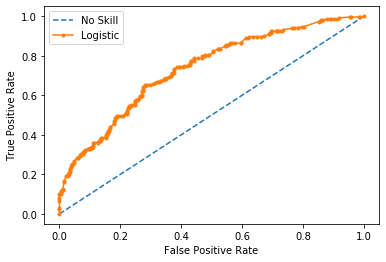

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from src.visualization.visualize import eval_metrics

clf = GradientBoostingClassifier(n_estimators=15, learning_rate=0.1, max_features=10, max_depth=2, random_state=0).fit(X_us, y_us)
y_pred = clf.predict_proba(X_val_us)[:, 1]
eval_metrics(y_pred, y_val_us, praba_threshold=0.5)

In [5]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
GP,1,0.608852,0.578813,0.578221,0.554121,0.279088,0.131057,0.127092,0.0566876,0.523388,0.518505,0.155622,0.397407,0.49126,0.482337,0.409771,0.477958,0.174336,0.540929
MIN,0.608852,1,0.904794,0.895626,0.894693,0.236066,0.358639,0.373093,0.160781,0.76964,0.755363,0.213264,0.54212,0.774915,0.732307,0.645698,0.762287,0.246294,0.795683
PTS,0.578813,0.904794,1,0.989201,0.973504,0.302723,0.338022,0.34953,0.16062,0.867021,0.845169,0.258557,0.540955,0.696124,0.678288,0.581164,0.681787,0.217657,0.819864
FGM,0.578221,0.895626,0.989201,1,0.972856,0.343653,0.288381,0.298671,0.126789,0.813384,0.801284,0.209639,0.566851,0.70413,0.693421,0.557832,0.667382,0.230295,0.802689
FGA,0.554121,0.894693,0.973504,0.972856,1,0.142439,0.373179,0.398703,0.207651,0.790539,0.763245,0.265275,0.465227,0.639263,0.611419,0.627676,0.693247,0.176661,0.820078
FG%,0.279088,0.236066,0.302723,0.343653,0.142439,1,-0.271016,-0.331286,-0.316506,0.283834,0.34096,-0.18748,0.543682,0.431488,0.494567,-0.132458,0.0756966,0.286814,0.131134
3P Made,0.131057,0.358639,0.338022,0.288381,0.373179,-0.271016,1,0.978929,0.588492,0.152872,0.0902346,0.324592,-0.203785,0.0782637,-0.0142016,0.381616,0.307054,-0.0957905,0.232666
3PA,0.127092,0.373093,0.34953,0.298671,0.398703,-0.331286,0.978929,1,0.578087,0.167858,0.102143,0.338272,-0.216128,0.0716292,-0.0230259,0.416193,0.339294,-0.102811,0.256353
3P%,0.0566876,0.160781,0.16062,0.126789,0.207651,-0.316506,0.588492,0.578087,1,0.0227263,-0.0462926,0.346009,-0.291133,-0.0975711,-0.174137,0.297509,0.201423,-0.16563,0.102572
FTM,0.523388,0.76964,0.867021,0.813384,0.790539,0.283834,0.152872,0.167858,0.0227263,1,0.975629,0.273789,0.546677,0.627296,0.631278,0.493638,0.592681,0.205753,0.775101


In [15]:
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)
X_val_sm, y_val_sm = sm.fit_resample(X_val, y_val)

non_cor_features = ['GP', 'PTS', 'FG%', '3PA', 'FTM', 'OREB', 'AST', 'STL', 'BLK', 'TOV']

X_smr = X_sm[non_cor_features]
X_val_smr = X_val_sm[non_cor_features]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0).fit(X_smr, y_sm)
y_pred = clf.predict_proba(X_val_smr)[:,1]
print(f'ROC_AUC Score for top x features: \t {round(roc_auc_score(y_val_sm, y_pred),3)}')

ROC_AUC Score for top x features: 	 0.897


In [17]:
test_data_xr = test_data_x[non_cor_features]
submission = clf.predict_proba(test_data_xr)[:,1]
submission = pd.DataFrame({'Id':test_data['Id'], 'TARGET_5Yrs':submission})
submission.to_csv("../../data/submission/0208_xgb_reduced.csv", index=False)

In [35]:
from numpy import mean
from numpy import isnan
from numpy import asarray
from numpy import polyfit
from scipy.stats import pearsonr
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
 
# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LogisticRegression())
    models.append(RidgeClassifier())
    models.append(SGDClassifier())
    models.append(PassiveAggressiveClassifier())
    models.append(KNeighborsClassifier())
    models.append(DecisionTreeClassifier())
    models.append(ExtraTreeClassifier())
    models.append(LinearSVC())
    models.append(SVC())
    models.append(GaussianNB())
    models.append(AdaBoostClassifier())
    models.append(BaggingClassifier())
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    return models

def get_models_p2():
    models = list()
    models.append(GaussianProcessClassifier())
    models.append(GradientBoostingClassifier())
    models.append(LinearDiscriminantAnalysis())
    models.append(QuadraticDiscriminantAnalysis())
    return models

# evaluate the model using a given test condition
def evaluate_model(X, y, cv, model):
    # get the dataset
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return mean(scores)

In [38]:
# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()

In [39]:
# evaluate each model
for model in models:
    # evaluate model using each test condition
    print(f'-------- Evaluating {model} -------- ')
    cv_mean = evaluate_model(X_train, y_train, cv, model)
    ideal_mean = evaluate_model(X_train, y_train, ideal_cv, model)
    # check for invalid results
    if isnan(cv_mean) or isnan(ideal_mean):
        continue
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)
    # summarize progress
    print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))

-------- Evaluating LogisticRegression() -------- 
>LogisticRegression: ideal=0.831, cv=0.831
-------- Evaluating RidgeClassifier() -------- 
>RidgeClassifier: ideal=0.831, cv=0.831
-------- Evaluating SGDClassifier() -------- 
>SGDClassifier: ideal=0.831, cv=0.831
-------- Evaluating PassiveAggressiveClassifier() -------- 
>PassiveAggressiveClassifier: ideal=0.738, cv=0.720
-------- Evaluating KNeighborsClassifier() -------- 
>KNeighborsClassifier: ideal=0.812, cv=0.811
-------- Evaluating DecisionTreeClassifier() -------- 
>DecisionTreeClassifier: ideal=0.726, cv=0.729
-------- Evaluating ExtraTreeClassifier() -------- 
>ExtraTreeClassifier: ideal=0.732, cv=0.733
-------- Evaluating LinearSVC() -------- 
>LinearSVC: ideal=0.831, cv=0.831
-------- Evaluating SVC() -------- 
>SVC: ideal=0.831, cv=0.831
-------- Evaluating GaussianNB() -------- 
>GaussianNB: ideal=0.579, cv=0.579
-------- Evaluating AdaBoostClassifier() -------- 
>AdaBoostClassifier: ideal=0.827, cv=0.827
-------- Evalu

In [ ]:
# LinearSVC, 
# LogisticRegression, 
# RidgeClassifer, 
# SGDClassifer,
# BaggingClassifier,
# RandomForestClassifier

Correlation: 0.998


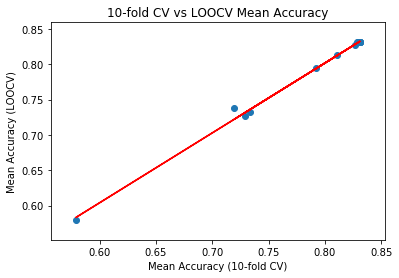

In [40]:
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)
# scatter plot of results
pyplot.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
pyplot.plot(cv_results, line, color='r')
# label the plot
pyplot.title('10-fold CV vs LOOCV Mean Accuracy')
pyplot.xlabel('Mean Accuracy (10-fold CV)')
pyplot.ylabel('Mean Accuracy (LOOCV)')
# show the plot
pyplot.show()